In [28]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
import chainconsumer as cc
import zodiax as zdx
import alphacen as ac
import utils

import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'monospace'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [59]:
param_list = ['sep', 'pa', 'logF', 'cont']
initial_values = [5, 1, 6.8, 3.37]

class Model(zdx.Base):
    sep : float
    pa : float
    logF : float
    cont : float
    source : object

    def __init__(self, sep=5, pa=1.5, logF=7, cont=3.37, source=None):
        self.sep = sep
        self.pa = pa
        self.logF = logF
        self.cont = cont
        self.source = source

    def model(self, source):

        psf_obj = source
        psf_obj.sep = self.sep
        psf_obj.pa = jnp.rad2deg(self.pa)
        psf_obj.flux = 10 ** self.logF
        psf_obj.cont = self.cont

        optics, source = psf_obj.GetInstrument()
        image = optics.model(source)

        return image

source = ac.AlphaCenPSF(mask_dir='data/toliman_pupil.npy', n_wavels=3)

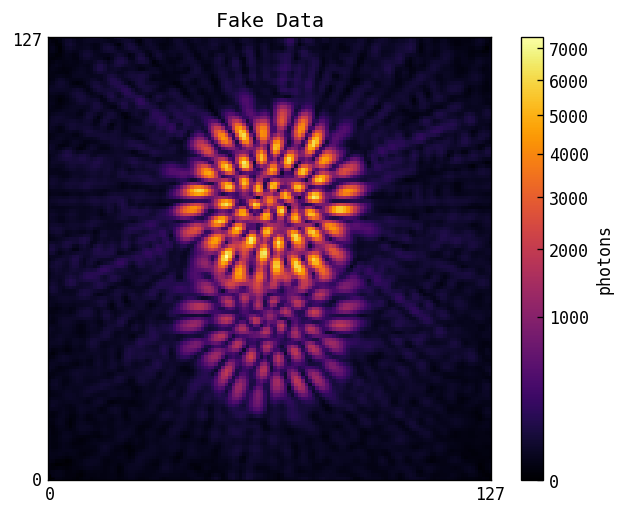

In [60]:
print(Model().set('sep',1.0))

In [116]:

data = Model(*initial_values).model(source)
print(Model(*initial_values))
utils.PlotSqrtPSF(data, title='Fake Data')

In [117]:
def sampling_fn(data, model):

    paths = ['sep', 'pa', 'logF', 'cont']

    # Define priors
    values = [npy.sample('sep', dist.Uniform(0, 15)),
              npy.sample('pa', dist.Uniform(0, 2*jnp.pi)),
              npy.sample('logF', dist.Uniform(6, 8.5)),
              npy.sample('cont', dist.Uniform(1, 10)),
              # npy.sample('rad', dist.Uniform(0, 5)),
              # npy.sample('ang', dist.Uniform(0, 2*jnp.pi))
              ]

    # scale = npy.sample("scale", dist.HalfNormal(1))

    # Sample from the posterior distribution
    data = data.flatten()
    with npy.plate("data", len(data)):
        # with npy.plate("scale", len(data)):
        # model_sampler = dist.Normal(
        #     model.set(paths, values).model().flatten(), scale=scale)
        model_sampler = dist.Normal(
            model.set(paths, values).model().flatten(), scale=0.2)
        return npy.sample("Sampler", model_sampler, obs=data)

In [ ]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(sampling_fn),
    num_warmup=5000,
    num_samples=5000,
)

model_instance =
sampler.run(jr.PRNGKey(0), data, Model(), init_params={"sep": 2, "pa": 2, "logF": 6, "cont": 2})

sampler.print_summary()
values_out = sampler.get_samples()

warmup:   9%|▊         | 60/700 [05:53<1:48:41, 10.19s/it, 1023 steps of size 8.60e-10. acc. prob=0.63]

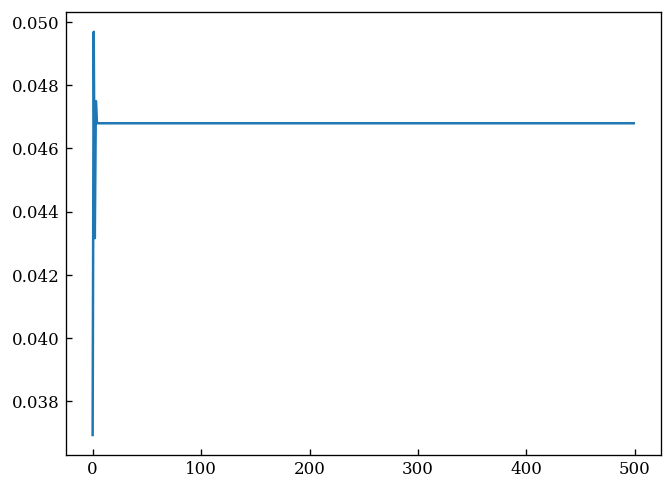

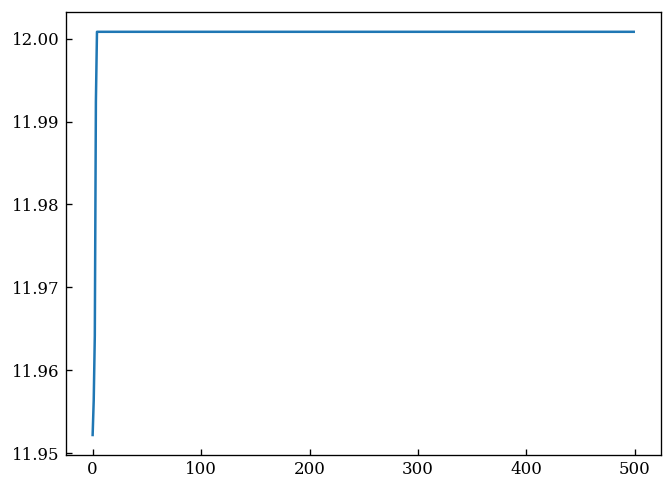

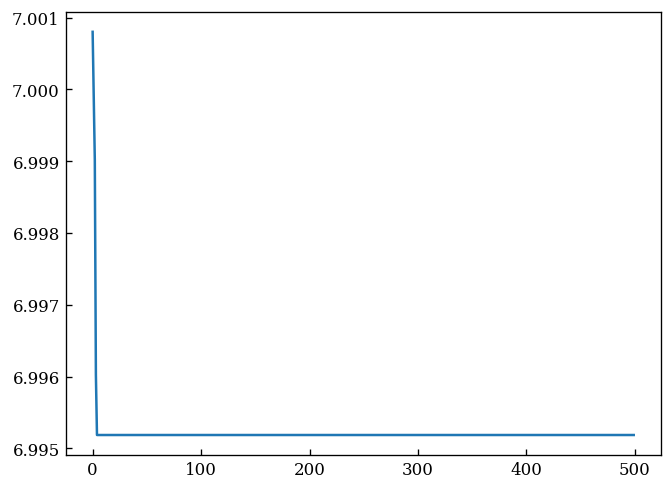

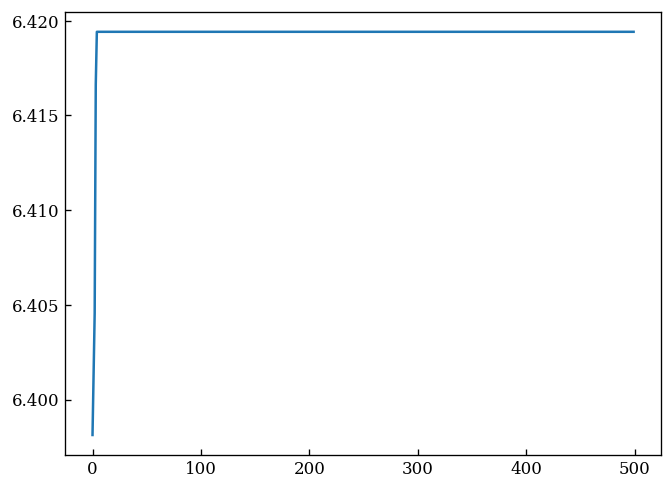

In [108]:
values_out

{'sep': Array(10., dtype=float32), 'pa': Array(0., dtype=float32), 'logF': Array(6.493388, dtype=float32), 'cont': Array(3.372873, dtype=float32)}


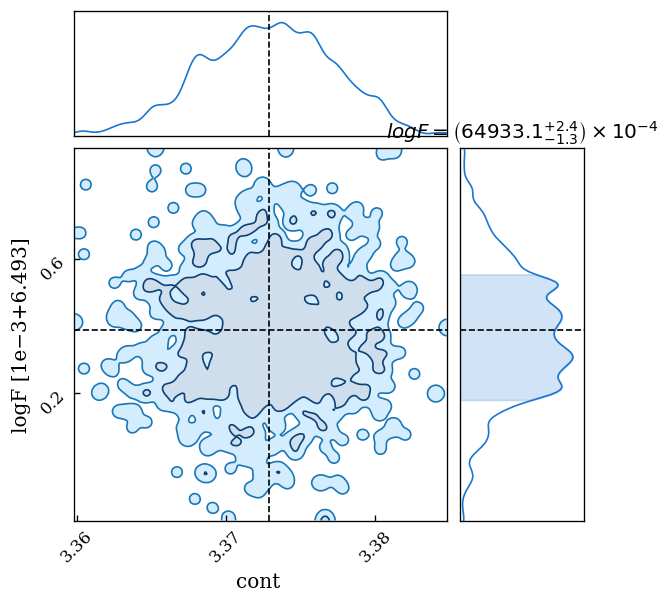

In [103]:
model

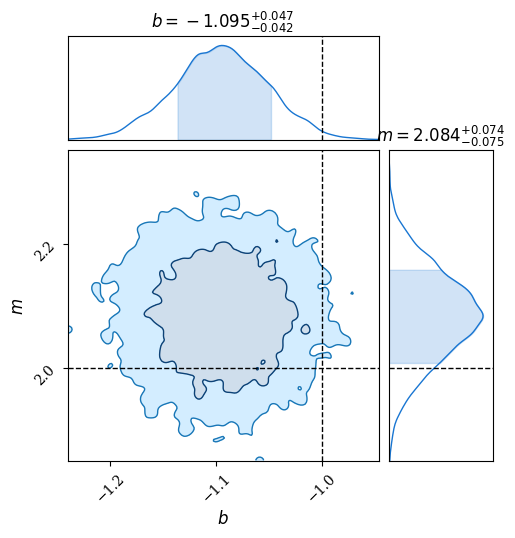

In [21]:
chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot(truth={"$m$": 2, "$b$": -1, 'scale': 0.2})
fig.set_size_inches((5,5))

In [22]:
test_model = model.set(['m', 'b'], [values_out['$m$'].mean(), values_out['$b$'].mean()])

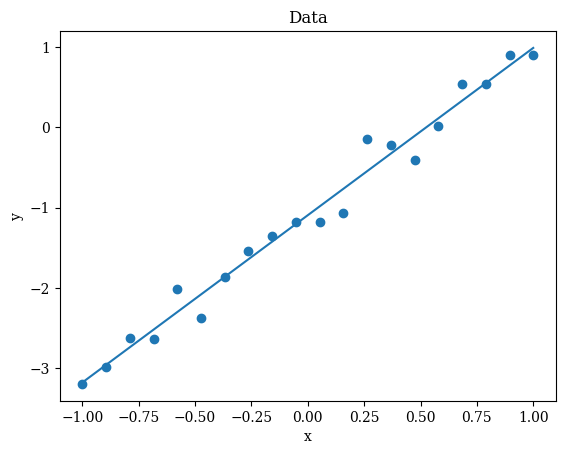

In [23]:
fig, ax = plt.subplots()
ax.scatter(data_x, data_y)
ax.plot(data_x, test_model.model())
ax.set(
    xlabel="x",
    ylabel="y",
    title="Data"
)
plt.show()
